# PWC[3]  -- with negative piece in the center

[grid] evaluated 828 cells, skipped 985; elapsed ~2407.0s
  - guard (A.9) rejects: 737
  - sim exceptions     : 248
[TOTAL] argmin at B*=20.6, δ*=0.1,  J_tot*=-1.76048


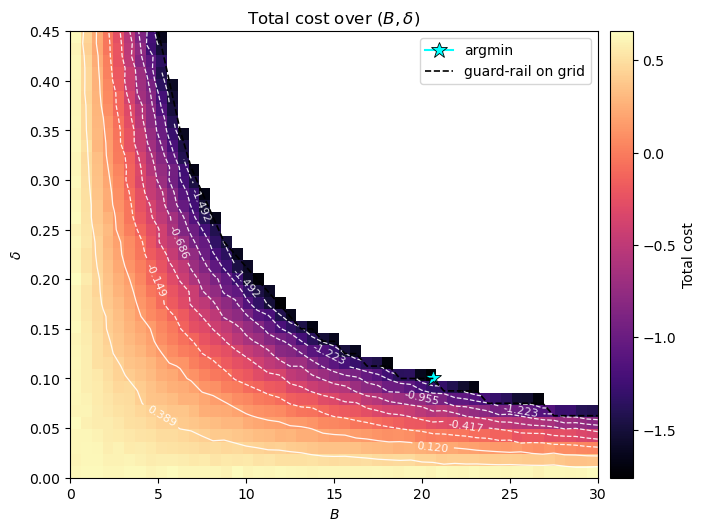

[saved] figs/negwin_total_cost_heatmap.png


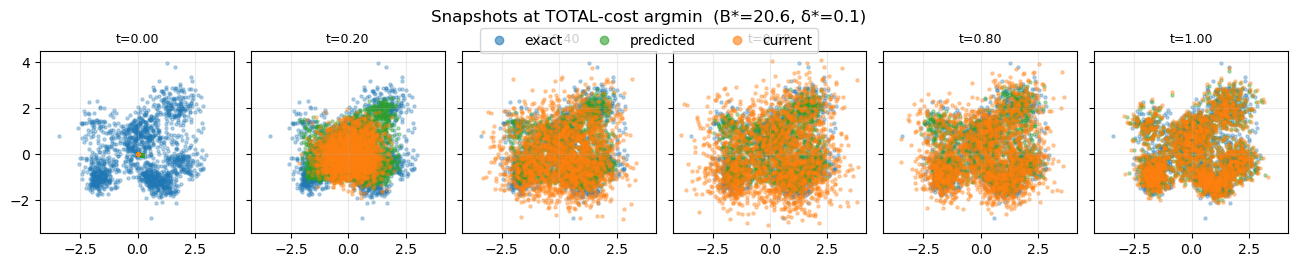

[saved] figs/negwin_total_cost_argmin_snapshots.png
[KINETIC] argmin at B*=8.75, δ*=0,  J_kin*=0.595702


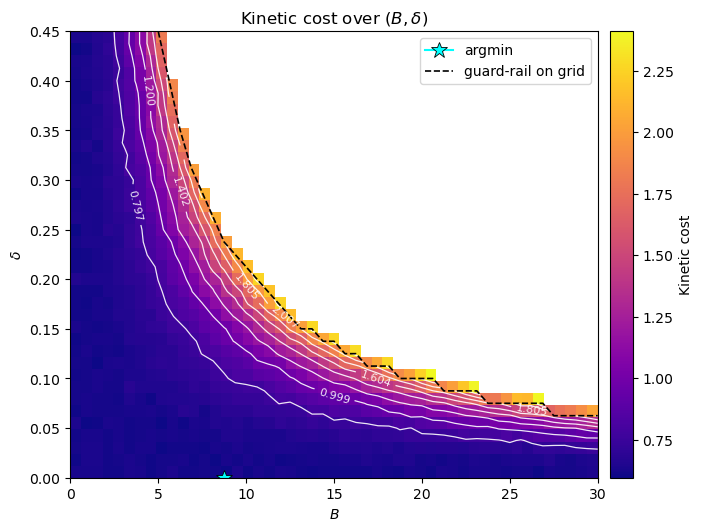

[saved] figs/negwin_kinetic_cost_heatmap.png


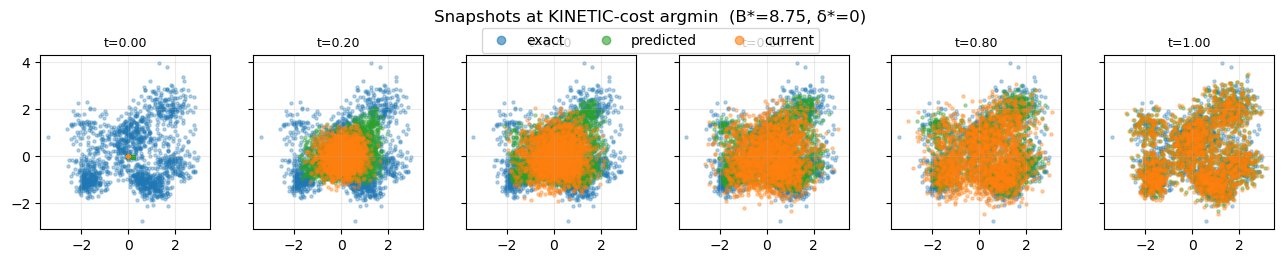

[saved] figs/negwin_kinetic_cost_argmin_snapshots.png


In [3]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, pertA

os.makedirs("figs", exist_ok=True)

# ============================================================
# Negative-window (B, δ) study with (A.9) guard
#   • Closed forms for a±, b−, c− (negative window)
#   • Enforce only Eq. (A.9) with a small margin (scan never crosses it)
#   • Outputs 4 figures:
#       - figs/negwin_total_cost_heatmap.png
#       - figs/negwin_total_cost_argmin_snapshots.png
#       - figs/negwin_kinetic_cost_heatmap.png
#       - figs/negwin_kinetic_cost_argmin_snapshots.png
# ============================================================

# -------- Guard-rail (Appendix A):  tL*sqrt(B)*tan(delta*sqrt(B)) < 1 --------
EPS_A9   = 1e-3   # safety margin for (A.9)
TCLAMP   = 0.02   # clamp away from endpoints in ALL evaluations
def admissible_A9(B, delta, eps=EPS_A9):
    if B < 0.0: return False
    if not (0.0 <= delta < 0.5): return False
    s  = math.sqrt(B)
    tL = (1.0 - delta)/2.0
    if s == 0.0 or delta == 0.0:
        return True
    # Guard: tL * s * tan(s*delta) < 1 - eps  (ensures a_plus stays in + branch w/o hitting pole)
    val = tL * s * math.tan(s*delta)
    return val <= (1.0 - float(eps))

# -------- Explicit Negative-window schedule (closed forms) --------
class NegativeWindowScheduleExplicit:
    """
    β(t) = −B on |t−1/2| < δ; 0 otherwise.
    Provides: a_plus(t), a_plus_1(), a_minus(t), b_minus(t), c_minus(t), beta_of(t).
    All time evaluations are clamped to [TCLAMP, 1−TCLAMP].
    """
    def __init__(self, B=1.0, delta=0.1, t_floor=TCLAMP):
        assert B >= 0.0 and (0.0 <= delta < 0.5)
        self.B       = float(B)
        self.delta   = float(delta)
        self.s       = math.sqrt(self.B)
        self.t_floor = float(t_floor)
        self.tL      = (1.0 - self.delta)/2.0
        self.tR      = (1.0 + self.delta)/2.0
        self.A0      = 2.0 / max(1.0 - self.delta, 1e-12)  # a^(-)(t_R) = 2/(1−δ)
        # Forward (+) integration constant on the middle interval (tan branch):
        if self.s > 0.0 and self.delta > 0.0:
            self.C_L = math.atan( 1.0/(max(self.tL,1e-12)*self.s) ) + self.tL*self.s
        else:
            self.C_L = None

    def _clamp(self, t):
        t = float(t)
        return min(max(t, self.t_floor), 1.0 - float(self.t_floor))

    def beta_of(self, t):
        t = float(t)
        return -self.B if (self.tL < t < self.tR) else 0.0

    # ---------- forward (+) ----------
    def a_plus(self, t):
        t = self._clamp(t)
        if t <= self.tL:
            return 1.0/max(t, 1e-12)
        elif t <= self.tR:
            if not (self.s>0 and self.delta>0):
                return 1.0/max(t,1e-12)
            phi = self.C_L - self.s*t
            return self.s*math.tan(phi)
        else:
            aR = self.a_plus(self.tR)
            den = 1.0 + aR*(t - self.tR)
            return aR / max(den, 1e-12)

    def a_plus_1(self):
        aR  = self.a_plus(self.tR)
        den = (1.0 - self.tR) + 1.0/max(aR,1e-12)
        return 1.0/max(den, 1e-12)

    # ---------- backward (−) ----------
    def a_minus(self, t):
        t = self._clamp(t)
        if t >= self.tR:
            return 1.0/max(1.0 - t, 1e-12)
        elif t >= self.tL:
            if not (self.s>0 and self.delta>0):
                return 1.0/max(1.0 - t, 1e-12)
            th  = self.s*(self.tR - t)
            den = self.s + self.A0*math.tan(th)
            den = den if abs(den)>1e-12 else (1e-12*np.sign(den) if den!=0 else 1e-12)
            num = self.s*(self.A0 - self.s*math.tan(th))
            return num/den
        else:
            aL = self.a_minus(self.tL)
            return aL / max(1.0 + aL*(self.tL - t), 1e-12)

    def b_minus(self, t):
        t = self._clamp(t)
        if t >= self.tR:
            return 1.0/max(1.0 - t, 1e-12)
        elif t >= self.tL:
            if not (self.s>0 and self.delta>0):
                return 1.0/max(1.0 - t, 1e-12)
            a  = self.a_minus(t)
            return self.A0 * math.sqrt( (self.B + a*a) / (self.B + self.A0*self.A0) )
        else:
            aL = self.a_minus(self.tL)
            bL = self.A0 * math.sqrt( (self.B + aL*aL) / (self.B + self.A0*self.A0) )
            a  = self.a_minus(t)
            return bL * (a/aL)

    def c_minus(self, t):
        t = self._clamp(t)
        if t >= self.tR:
            return 1.0/max(1.0 - t, 1e-12)
        elif t >= self.tL:
            if not (self.s>0 and self.delta>0):
                return 1.0/max(1.0 - t, 1e-12)
            a  = self.a_minus(t)
            return self.A0 - (self.A0*self.A0/(self.B + self.A0*self.A0))*(self.A0 - a)
        else:
            aL = self.a_minus(self.tL)
            bL = self.A0 * math.sqrt( (self.B + aL*aL) / (self.B + self.A0*self.A0) )
            cL = self.A0 - (self.A0*self.A0/(self.B + self.A0*self.A0))*(self.A0 - aL)
            a  = self.a_minus(t)
            return cL - (bL*bL/(aL*aL))*(aL - a)

# -------- Cost simulators (shared) --------
def _phase(B, d):
    """Deterministic tiny phase to de-alias time samples across the grid."""
    return (((int(round(B*1e6))*10007) ^ (int(round(d*1e6))*10037)) & 0xffffffff) / 2**32

def _teff(t, t_floor=TCLAMP):
    return min(max(float(t), float(t_floor)), 1.0 - float(t_floor))

def eval_costs_full(sched, gmm, M=1500, T=600, seed=0, t_floor=TCLAMP):
    """Midpoint EM with X(0)=0. Returns (J_tot, J_kin, J_pot)."""
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    X   = np.zeros((M, gmm.d), float)
    J_kin = 0.0; J_pot = 0.0
    ph = _phase(getattr(sched, 'B', 0.0), getattr(sched, 'delta', 0.0))
    for n in range(T):
        t_mid = (n + 0.5 + ph)/T
        t_eff = _teff(t_mid, t_floor)
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(t_eff))
        b_m   = float(sched.b_minus(t_eff))
        u     = b_m*yhat - a_m*X
        J_kin += 0.5 * float(np.mean(np.sum(u*u, axis=1))) * dt
        beta_t = float(sched.beta_of(t_eff)) if hasattr(sched,'beta_of') else 0.0
        J_pot += 0.5 * beta_t * float(np.mean(np.sum(X*X, axis=1))) * dt
        X     += u*dt + rng.normal(size=X.shape)*math.sqrt(dt)
    return J_kin + J_pot, J_kin, J_pot

def simulate_snapshots(sched, gmm, Y_ref, M=2000, T=800, seed=123, N_cols=6, t_floor=TCLAMP):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    X    = np.zeros((M, gmm.d), float)
    idx  = np.linspace(0, T-1, N_cols).round().astype(int); ptr = 0
    times = []; snaps_X = []; snaps_Yh = []
    ph = _phase(getattr(sched, 'B', 0.0), getattr(sched, 'delta', 0.0))
    for n in range(T):
        t_mid = (n + 0.5 + ph) / T
        t_eff = _teff(t_mid, t_floor)
        yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
        a_m   = float(sched.a_minus(t_eff))
        b_m   = float(sched.b_minus(t_eff))
        u     = b_m*yhat - a_m*X
        if ptr < len(idx) and n == idx[ptr]:
            times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1
        X     += u*dt + rng.normal(size=X.shape)*math.sqrt(dt)
    return np.array(times, float), snaps_X, snaps_Yh

# -------- Target GMM (use your API's 'pertA') --------
gmm = pertA

# Reference samples (for snapshot plot limits)
seed_base   = 20241015
M_heat      = 1500
rng_global  = np.random.default_rng(seed_base)
Y_ref, _    = sample_gmm(gmm, M_heat, rng_global)

# ============================================================
# Scan domain (A.9-admissible only) and compute costs
# ============================================================
B_vals = np.linspace(0.0, 30.0, 49)     # 0..30
D_vals = np.linspace(0.0, 0.45, 37)     # 0..0.45
NB, ND  = len(B_vals), len(D_vals)

H_tot  = np.full((ND, NB), np.nan, float)
H_kin  = np.full_like(H_tot, np.nan)
H_pot  = np.full_like(H_tot, np.nan)
mask_A9= np.zeros_like(H_tot, dtype=bool)

T_heat_base = 550  # steps scale ~ sqrt(B)
t0 = time.time()
n_eval = 0
n_skip_A9 = 0
n_skip_sim = 0

for j, B in enumerate(B_vals):
    T_eff = int(round(T_heat_base * max(1.0, 1.25*math.sqrt(B))))
    for i, delta in enumerate(D_vals):
        if not admissible_A9(B, delta):
            mask_A9[i, j] = True; n_skip_A9 += 1; continue
        sched = NegativeWindowScheduleExplicit(B=float(B), delta=float(delta), t_floor=TCLAMP)
        seed_sim = int(seed_base + 1009 + 10007*j + 10037*i + 200003*T_eff) & 0x7fffffff
        try:
            Jtot, Jkin, Jpot = eval_costs_full(sched, gmm, M=M_heat, T=T_eff, seed=seed_sim, t_floor=TCLAMP)
        except Exception:
            mask_A9[i, j] = True; n_skip_sim += 1; continue
        H_tot[i, j] = Jtot; H_kin[i, j] = Jkin; H_pot[i, j] = Jpot; n_eval += 1

elapsed = time.time() - t0
print(f"[grid] evaluated {n_eval} cells, skipped {n_skip_A9 + n_skip_sim}; elapsed ~{elapsed:.1f}s")
print(f"  - guard (A.9) rejects: {n_skip_A9}")
print(f"  - sim exceptions     : {n_skip_sim}")

# Frontier δ_max(B) on the grid (largest δ passing A.9 at each B)
delta_frontier = np.full_like(B_vals, np.nan, dtype=float)
for j in range(NB):
    good = np.where(~mask_A9[:, j])[0]
    if good.size:
        delta_frontier[j] = D_vals[good.max()]

# ============================================================
# TOTAL heatmap + snapshots
# ============================================================
if np.isfinite(H_tot).sum() == 0:
    raise RuntimeError("No finite TOTAL costs on the scanned grid.")

imin = np.nanargmin(H_tot)
imin_i, imin_j = np.unravel_index(imin, H_tot.shape)
B_star_tot, D_star_tot = float(B_vals[imin_j]), float(D_vals[imin_i])
J_star_tot = float(H_tot[imin_i, imin_j])
print(f"[TOTAL] argmin at B*={B_star_tot:.3g}, δ*={D_star_tot:.3g},  J_tot*={J_star_tot:.6g}")

fig, ax = plt.subplots(figsize=(8.2, 5.8))
Z = np.ma.masked_invalid(H_tot)
B_edges = np.linspace(B_vals[0], B_vals[-1], NB+1)
D_edges = np.linspace(D_vals[0], D_vals[-1], ND+1)
im = ax.pcolormesh(B_edges, D_edges, Z, cmap="magma", shading="auto")
cb = fig.colorbar(im, ax=ax, pad=0.02); cb.set_label(r"Total cost")
finite_vals = Z.compressed(); vmin, vmax = float(np.min(finite_vals)), float(np.max(finite_vals))
CS = ax.contour(B_vals, D_vals, Z, levels=np.linspace(vmin, vmax, 10), colors="w", linewidths=0.9, alpha=0.9)
ax.clabel(CS, inline=True, fmt="%.3f", fontsize=8)
ax.plot([B_star_tot], [D_star_tot], marker="*", ms=12, color="cyan", mec="k", mew=0.6, label="argmin")
if np.isfinite(delta_frontier).any():
    ax.plot(B_vals, delta_frontier, 'k--', lw=1.2, label="guard-rail on grid")
ax.legend(loc="upper right", frameon=True)
ax.set_xlabel(r"$B$")
ax.set_ylabel(r"$\delta$")
ax.set_title("Total cost over $(B,\delta)$")
fname_tot_map = "figs/negwin_total_cost_heatmap.png"
try: fig.savefig(fname_tot_map, dpi=300, bbox_inches="tight")
except Exception: fig.savefig(fname_tot_map, dpi=300)
plt.show(); print("[saved]", fname_tot_map)

# Snapshots at TOTAL argmin
T_snap = int(round(650 * max(1.0, 2.0*math.sqrt(B_star_tot))))
sched_tot = NegativeWindowScheduleExplicit(B_star_tot, D_star_tot, t_floor=TCLAMP)
times, snaps_X, snaps_Yh = simulate_snapshots(sched_tot, gmm, Y_ref, M=2000, T=T_snap,
                                              seed=seed_base+333, N_cols=6, t_floor=TCLAMP)

XY_all = np.vstack([Y_ref] + snaps_X + snaps_Yh)
xmin, ymin = XY_all.min(axis=0); xmax, ymax = XY_all.max(axis=0)
padx = 0.05*(xmax-xmin+1e-9); pady = 0.05*(ymax-ymin+1e-9)
xlim = (xmin-padx, xmax+padx); ylim = (ymin-pady, ymax+pady)
fig, axs = plt.subplots(1, len(times), figsize=(2.15*len(times), 2.25), sharex=True, sharey=True, constrained_layout=True)
blue, green, orange = "C0", "#2ca02c", "C1"
for j, ax in enumerate(np.atleast_1d(axs)):
    Xj, Yhj = snaps_X[j], snaps_Yh[j]
    ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color=blue,   label="exact" if j==0 else None)
    ax.scatter(Yhj[:,0],   Yhj[:,1],   s=5, alpha=0.35, color=green,  label="predicted" if j==0 else None)
    ax.scatter(Xj[:,0],    Xj[:,1],    s=5, alpha=0.35, color=orange, label="current" if j==0 else None)
    ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
    ax.set_title(f"t={times[j]:.2f}", fontsize=9); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
if len(times) > 0:
    handles = [
        plt.Line2D([0],[0], marker="o", linestyle="", color=blue,   alpha=0.6, label="exact"),
        plt.Line2D([0],[0], marker="o", linestyle="", color=green,  alpha=0.6, label="predicted"),
        plt.Line2D([0],[0], marker="o", linestyle="", color=orange, alpha=0.6, label="current"),
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=True)
fig.suptitle(f"Snapshots at TOTAL-cost argmin  (B*={B_star_tot:.3g}, δ*={D_star_tot:.3g})", y=1.10)
fname_tot_snap = "figs/negwin_total_cost_argmin_snapshots.png"
try: fig.savefig(fname_tot_snap, dpi=300, bbox_inches="tight")
except Exception: fig.savefig(fname_tot_snap, dpi=300)
plt.show(); print("[saved]", fname_tot_snap)

# ============================================================
# KINETIC heatmap + snapshots
# ============================================================
if np.isfinite(H_kin).sum() == 0:
    raise RuntimeError("No finite KINETIC costs on the scanned grid.")

imin_k = np.nanargmin(H_kin)
ik_i, ik_j = np.unravel_index(imin_k, H_kin.shape)
B_star_kin, D_star_kin = float(B_vals[ik_j]), float(D_vals[ik_i])
J_star_kin = float(H_kin[ik_i, ik_j])
print(f"[KINETIC] argmin at B*={B_star_kin:.3g}, δ*={D_star_kin:.3g},  J_kin*={J_star_kin:.6g}")

fig, ax = plt.subplots(figsize=(8.2, 5.8))
Zk = np.ma.masked_invalid(H_kin)
im = ax.pcolormesh(B_edges, D_edges, Zk, cmap="plasma", shading="auto")
cb = fig.colorbar(im, ax=ax, pad=0.02); cb.set_label(r"Kinetic cost")
fv = Zk.compressed(); vmin, vmax = float(np.min(fv)), float(np.max(fv))
CSk = ax.contour(B_vals, D_vals, Zk, levels=np.linspace(vmin, vmax, 10), colors="w", linewidths=0.9, alpha=0.9)
ax.clabel(CSk, inline=True, fmt="%.3f", fontsize=8)
ax.plot([B_star_kin], [D_star_kin], marker="*", ms=12, color="cyan", mec="k", mew=0.6, label="argmin")
if np.isfinite(delta_frontier).any():
    ax.plot(B_vals, delta_frontier, 'k--', lw=1.2, label="guard-rail on grid")
ax.legend(loc="upper right", frameon=True)
ax.set_xlabel(r"$B$")
ax.set_ylabel(r"$\delta$")
ax.set_title("Kinetic cost over $(B,\delta)$")
fname_kin_map = "figs/negwin_kinetic_cost_heatmap.png"
try: fig.savefig(fname_kin_map, dpi=300, bbox_inches="tight")
except Exception: fig.savefig(fname_kin_map, dpi=300)
plt.show(); print("[saved]", fname_kin_map)

# Snapshots at KINETIC argmin
T_snap_k = int(round(650 * max(1.0, 2.0*math.sqrt(B_star_kin))))
sched_kin = NegativeWindowScheduleExplicit(B_star_kin, D_star_kin, t_floor=TCLAMP)
times_k, snaps_X_k, snaps_Yh_k = simulate_snapshots(sched_kin, gmm, Y_ref, M=2000, T=T_snap_k,
                                                    seed=seed_base+777, N_cols=6, t_floor=TCLAMP)

XY_all_k = np.vstack([Y_ref] + snaps_X_k + snaps_Yh_k)
xmin, ymin = XY_all_k.min(axis=0); xmax, ymax = XY_all_k.max(axis=0)
padx = 0.05*(xmax-xmin+1e-9); pady = 0.05*(ymax-ymin+1e-9)
xlim = (xmin-padx, xmax+padx); ylim = (ymin-pady, ymax+pady)
fig, axs = plt.subplots(1, len(times_k), figsize=(2.15*len(times_k), 2.25), sharex=True, sharey=True, constrained_layout=True)
for j, ax in enumerate(np.atleast_1d(axs)):
    Xj, Yhj = snaps_X_k[j], snaps_Yh_k[j]
    ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color=blue,   label="exact" if j==0 else None)
    ax.scatter(Yhj[:,0],   Yhj[:,1],   s=5, alpha=0.35, color=green,  label="predicted" if j==0 else None)
    ax.scatter(Xj[:,0],    Xj[:,1],    s=5, alpha=0.35, color=orange, label="current" if j==0 else None)
    ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
    ax.set_title(f"t={times_k[j]:.2f}", fontsize=9); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
if len(times_k) > 0:
    handles = [
        plt.Line2D([0],[0], marker="o", linestyle="", color=blue,   alpha=0.6, label="exact"),
        plt.Line2D([0],[0], marker="o", linestyle="", color=green,  alpha=0.6, label="predicted"),
        plt.Line2D([0],[0], marker="o", linestyle="", color=orange, alpha=0.6, label="current"),
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=True)
fig.suptitle(f"Snapshots at KINETIC-cost argmin  (B*={B_star_kin:.3g}, δ*={D_star_kin:.3g})", y=1.10)
fname_kin_snap = "figs/negwin_kinetic_cost_argmin_snapshots.png"
try: fig.savefig(fname_kin_snap, dpi=300, bbox_inches="tight")
except Exception: fig.savefig(fname_kin_snap, dpi=300)
plt.show(); print("[saved]", fname_kin_snap)
